In [139]:

import pandas as pd
import numpy as np
import sys
sys.path.append('../..')
from utils import convert_to_uM

In [ ]:
df = pd.read_csv('../../data/organism_w_llama.csv')

In [141]:
df

,Unnamed: 0,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,...,units,uo_units,upper_value,value,mtb_strain,mentions_resistance,resistant_to,mutant,mutant_type,checkerboard
0,0,NaN,NaN,34021,[],CHEMBL715914,In vitro antibacterial activity of compound ag...,F,NaN,NaN,...,ug ml-1,UO_0000274,NaN,0.500,H37Rv ATCC 9660,False,False,False,False,False
1,1,NaN,NaN,34115,[],CHEMBL715914,In vitro antibacterial activity of compound ag...,F,NaN,NaN,...,ug ml-1,UO_0000274,NaN,1.000,H37Rv ATCC 9660,False,False,False,False,False
2,2,NaN,NaN,36502,[],CHEMBL715914,In vitro antibacterial activity of compound ag...,F,NaN,NaN,...,ug ml-1,UO_0000274,NaN,0.125,H37Rv ATCC 9660,False,False,False,False,False
3,3,NaN,NaN,42561,[],CHEMBL715914,In vitro antibacterial activity of compound ag...,F,NaN,NaN,...,ug ml-1,UO_0000274,NaN,0.125,H37Rv ATCC 9660,False,False,False,False,False
4,4,NaN,NaN,44868,[],CHEMBL715914,In vitro antibacterial activity of compound ag...,F,NaN,NaN,...,ug ml-1,UO_0000274,NaN,2.000,H37Rv ATCC 9660,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35037,54,NaN,NaN,15777196,[],CHEMBL3637834,GSK_TB: Minimum inhibitory concentration again...,F,NaN,NaN,...,uM,UO_0000065,NaN,5.000,clinical isolates,R,isoniazid and rifampicin,False,False,False
35038,55,NaN,NaN,15777197,[],CHEMBL3637834,GSK_TB: Minimum inhibitory concentration again...,F,NaN,NaN,...,uM,UO_0000065,NaN,1.300,clinical isolates,R,isoniazid and rifampicin,False,False,False
35039,56,NaN,NaN,15777198,[],CHEMBL3637834,GSK_TB: Minimum inhibitory concentration again...,F,NaN,NaN,...,uM,UO_0000065,NaN,0.900,clinical isolates,R,isoniazid and rifampicin,False,False,False
35040,57,NaN,NaN,15777199,[],CHEMBL3637834,GSK_TB: Minimum inhibitory concentration again...,F,NaN,NaN,...,uM,UO_0000065,NaN,1.300,clinical isolates,R,isoniazid and rifampicin,False,False,False


In [142]:
#remove outside typical range
df.data_validity_comment.value_counts()

data_validity_comment
Outside typical range    37
Name: count, dtype: int64

In [143]:
# remove rows with data_validity_comment == 'Outside typical range'
df = df[df.data_validity_comment != 'Outside typical range']

In [144]:
# remove rows with standard_flag == 0
df = df[df.standard_flag != 0]

In [145]:
df['standard_units'].unique()

array(['ug.mL-1', 'nM'], dtype=object)

In [146]:
# add column with mic in uM
mic_um = convert_to_uM(df, "canonical_smiles")

df['MIC_uM'] = mic_um

In [147]:
h37rv = df[df["mtb_strain"].isin(["H37Rv", "H37Rv ATCC 27294", "H37Rv ATCC 27294T"])]

In [148]:
h37rv['canonical_smiles'].nunique()

14520

In [149]:
(df['MIC_uM'] == 0).sum()

np.int64(0)

In [150]:
columns_to_convert = [
    "mtb_strain", 
    "mentions_resistance", 
    "resistant_to",
    "mutant", 
    "mutant_type", 
    "checkerboard"
]

# Convert all to stripped strings
for col in columns_to_convert:
    df[col] = df[col].astype(str).str.strip()

In [151]:
df

,Unnamed: 0,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,...,uo_units,upper_value,value,mtb_strain,mentions_resistance,resistant_to,mutant,mutant_type,checkerboard,MIC_uM
0,0,NaN,NaN,34021,[],CHEMBL715914,In vitro antibacterial activity of compound ag...,F,NaN,NaN,...,UO_0000274,NaN,0.500,H37Rv ATCC 9660,False,False,False,False,False,0.718111
1,1,NaN,NaN,34115,[],CHEMBL715914,In vitro antibacterial activity of compound ag...,F,NaN,NaN,...,UO_0000274,NaN,1.000,H37Rv ATCC 9660,False,False,False,False,False,1.072566
2,2,NaN,NaN,36502,[],CHEMBL715914,In vitro antibacterial activity of compound ag...,F,NaN,NaN,...,UO_0000274,NaN,0.125,H37Rv ATCC 9660,False,False,False,False,False,0.159985
3,3,NaN,NaN,42561,[],CHEMBL715914,In vitro antibacterial activity of compound ag...,F,NaN,NaN,...,UO_0000274,NaN,0.125,H37Rv ATCC 9660,False,False,False,False,False,0.137002
4,4,NaN,NaN,44868,[],CHEMBL715914,In vitro antibacterial activity of compound ag...,F,NaN,NaN,...,UO_0000274,NaN,2.000,H37Rv ATCC 9660,False,False,False,False,False,2.391296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35037,54,NaN,NaN,15777196,[],CHEMBL3637834,GSK_TB: Minimum inhibitory concentration again...,F,NaN,NaN,...,UO_0000065,NaN,5.000,clinical isolates,R,isoniazid and rifampicin,False,False,False,5.000000
35038,55,NaN,NaN,15777197,[],CHEMBL3637834,GSK_TB: Minimum inhibitory concentration again...,F,NaN,NaN,...,UO_0000065,NaN,1.300,clinical isolates,R,isoniazid and rifampicin,False,False,False,1.300000
35039,56,NaN,NaN,15777198,[],CHEMBL3637834,GSK_TB: Minimum inhibitory concentration again...,F,NaN,NaN,...,UO_0000065,NaN,0.900,clinical isolates,R,isoniazid and rifampicin,False,False,False,0.900000
35040,57,NaN,NaN,15777199,[],CHEMBL3637834,GSK_TB: Minimum inhibitory concentration again...,F,NaN,NaN,...,UO_0000065,NaN,1.300,clinical isolates,R,isoniazid and rifampicin,False,False,False,1.300000


In [152]:
import pandas as pd

# Exact strain names you want to keep
valid_strains = {
    "H37Rv",
    "H37Rv ATCC 27294",
    "H37Rv ATCC 27294T"
}

# Ensure columns are treated as strings to avoid dtype issues
df["data_status_h37rv"] = df.apply(
    lambda row: "llm_filtered" if (
        row["mtb_strain"] in valid_strains and
        row["mentions_resistance"] == "False" and
        row["mutant"] == "False" and
        row["checkerboard"] == "False"
    ) else "raw",
    axis=1
)

In [153]:
df["data_status_nr"] = df.apply(
    lambda row: "llm_filtered" if (
        row["mentions_resistance"] == "False" and
        row["checkerboard"] == "False"
    ) else "raw",
    axis=1
)

In [154]:
h37rv_filtered_data = df[df["data_status_h37rv"] == "llm_filtered"].copy(deep=True)
nr_filtered_data = df[df["data_status_nr"] == "llm_filtered"].copy(deep=True)
raw_data = df.copy(deep=True)

In [155]:
h37rv_filtered_data.canonical_smiles.nunique(), nr_filtered_data.canonical_smiles.nunique(), raw_data.canonical_smiles.nunique()

(14187, 18402, 18780)

In [156]:
# creates a new column to merge duplicate canonical_smiles MIC_uM using median
def merge_duplicates(df):
    # Group by canonical_smiles and calculate median, mean, std
    merged_df = df.groupby('canonical_smiles', as_index=False).agg({
        'MIC_uM': ['median', 'mean', 'std']
    })

    # Flatten column names
    merged_df.columns = ['canonical_smiles', 'MIC_uM_median', 'MIC_uM_mean', 'MIC_uM_std']

    # Merge stats back into original DataFrame
    df = pd.merge(df, merged_df, on='canonical_smiles')

    return df

#shuffle data
def add_log_column(df):
    df = df.copy() 
    df["mic_log"] = df["MIC_uM_median"].apply(lambda x: np.nan if x <= 0 else -np.log10(x))
    return df




In [157]:
# merging duplicates
h37rv_filtered_data = merge_duplicates(h37rv_filtered_data)
nr_filtered_data = merge_duplicates(nr_filtered_data)
raw_data = merge_duplicates(raw_data)

# data without duplicates
h37rv_filtered_data_no_duplicates = h37rv_filtered_data.drop_duplicates(subset=['canonical_smiles'])
nr_filtered_data_no_duplicates = nr_filtered_data.drop_duplicates(subset=['canonical_smiles'])
raw_data_no_duplicates = raw_data.drop_duplicates(subset=['canonical_smiles'])

# add log column
h37rv_filtered_data_no_duplicates = add_log_column(h37rv_filtered_data_no_duplicates)
nr_filtered_data_no_duplicates = add_log_column(nr_filtered_data_no_duplicates)
raw_data_no_duplicates = add_log_column(raw_data_no_duplicates)


In [163]:
# Step 1: Find canonical_smiles with duplicates in h37rv_filtered_data
duplicated_smiles = h37rv_filtered_data['canonical_smiles'][h37rv_filtered_data['canonical_smiles'].duplicated()].unique()
print( h37rv_filtered_data['canonical_smiles'][h37rv_filtered_data['canonical_smiles'].duplicated()].nunique())
# Step 2: Filter no_duplicates DataFrames to only those duplicated smiles
h37rv_dupes_only = h37rv_filtered_data_no_duplicates[h37rv_filtered_data_no_duplicates['canonical_smiles'].isin(duplicated_smiles)]
raw_dupes_only = raw_data_no_duplicates[raw_data_no_duplicates['canonical_smiles'].isin(duplicated_smiles)]

# Step 3: Merge on canonical_smiles
comparison_df = pd.merge(
    h37rv_dupes_only[['canonical_smiles', 'MIC_uM_median']],
    raw_dupes_only[['canonical_smiles', 'MIC_uM_median']],
    on='canonical_smiles',
    suffixes=('_h37rv', '_raw')
)

correlation = comparison_df[["MIC_uM_median_h37rv", "MIC_uM_median_raw"]].corr().iloc[0, 1]
print(f"Correlation between H37Rv and raw data for duplicated canonical_smiles: {correlation:.2f}")


comparison_mean_df = pd.merge(
    h37rv_dupes_only[['canonical_smiles', 'MIC_uM_mean']],
    raw_dupes_only[['canonical_smiles', 'MIC_uM_mean']],
    on='canonical_smiles',
    suffixes=('_h37rv', '_raw')
)
mean_corr = comparison_mean_df[["MIC_uM_mean_h37rv", "MIC_uM_mean_raw"]].corr().iloc[0, 1]
print("Correlation (raw means):", mean_corr)

# Step 4: Compute -log10 values (avoid log of zero)
comparison_df["log_median_h37rv"] = -np.log10(comparison_df["MIC_uM_median_h37rv"].replace(0, np.nan))
comparison_df["log_median_raw"] = -np.log10(comparison_df["MIC_uM_median_raw"].replace(0, np.nan))

log_corr = comparison_df[["log_median_h37rv", "log_median_raw"]].corr().iloc[0, 1]
print("Correlation (-log10 medians):", log_corr)



1848
Correlation between H37Rv and raw data for duplicated canonical_smiles: 0.99
Correlation (raw means): 0.9901972201411416
Correlation (-log10 medians): 0.9488768274256243


In [ ]:
# merging duplicates
h37rv_filtered_data = merge_duplicates(h37rv_filtered_data)
nr_filtered_data = merge_duplicates(nr_filtered_data)
raw_data = merge_duplicates(raw_data)

In [130]:
h37rv_filtered_data.shape, h37rv_filtered_data_no_duplicates.shape

((18262, 59), (14187, 60))

In [131]:
nr_filtered_data.shape, nr_filtered_data_no_duplicates.shape

((28126, 59), (18402, 60))

In [132]:
raw_data.shape, raw_data_no_duplicates.shape

((35002, 59), (18780, 60))

In [133]:
df[df['checkerboard']=='True'].shape[0], df[df['checkerboard']==False].shape[0], df.shape[0]

(212, 0, 35002)

In [134]:
df[df["mutant"] == "True"].shape[0], df[df["mutant"] == "False"].shape[0], df.shape[0]

(2062, 32940, 35002)

In [135]:
df[df["mentions_resistance"] != "False"].shape[0], df[df["mentions_resistance"] == "False"].shape[0], df.shape[0]

(6664, 28338, 35002)

In [ ]:
# h37rv_filtered_data_no_duplicates.to_csv('../../data/cv/h37rv_filtered_data_no_duplicates.csv', index=False)
# nr_filtered_data_no_duplicates.to_csv('../../data/cv/nr_filtered_data_no_duplicates.csv', index=False)
# raw_data_no_duplicates.to_csv('../../data/cv/raw_data_no_duplicates.csv', index=False)

In [110]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# === Plot style ===
sns.set_palette("colorblind")
plt.rcParams.update({
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 18
})


# === Helper functions ===
def safe_pearson(x, y):
    mask = x.notna() & y.notna()
    return pearsonr(x[mask], y[mask])[0] if mask.sum() >= 2 else np.nan

def annotate_outliers(ax, df, xcol, ycol, threshold=1.5):
    df = df.copy()
    df["diff"] = np.abs(df[xcol] - df[ycol])
    outliers = df[df["diff"] > threshold]
    for _, row in outliers.iterrows():
        ax.annotate("", xy=(row[xcol], row[ycol]), xytext=(row[xcol], row[ycol] + 0.1),
                    arrowprops=dict(arrowstyle="->", color="red", lw=1.5))
    return len(outliers)

# === Main function ===
def compare_datasets(ds1, ds2, ds1_label="DS1", ds2_label="Raw", output_path="comparison_plot.png"):
    # === Plot A: SMILES with duplicates in ds1 ===
    counts_ds1 = ds1.groupby("canonical_smiles").size().reset_index(name="count")
    duplicates = counts_ds1[counts_ds1["count"] > 1]["canonical_smiles"]

    ds1_dups_grouped = ds1[ds1["canonical_smiles"].isin(duplicates)].groupby(
        "canonical_smiles", as_index=False
    ).agg({
        "MIC_uM": ["median", "mean", "std"]
    })
    ds1_dups_grouped.columns = ["canonical_smiles", "MIC_uM_median", "MIC_uM_mean", "MIC_uM_std"]
    ds1_dups_grouped["mic_log_ds1"] = ds1_dups_grouped["MIC_uM_median"].apply(lambda x: np.nan if x <= 0 else -np.log10(x))

    ds2_dups_grouped = ds2[ds2["canonical_smiles"].isin(duplicates)].groupby(
        "canonical_smiles", as_index=False
    ).agg({
        "MIC_uM": ["median", "mean", "std"]
    })
    ds2_dups_grouped.columns = ["canonical_smiles", "MIC_uM_median", "MIC_uM_mean", "MIC_uM_std"]
    ds2_dups_grouped["mic_log_ds2"] = ds2_dups_grouped["MIC_uM_median"].apply(lambda x: np.nan if x <= 0 else -np.log10(x))

    merged_dups_only = pd.merge(ds1_dups_grouped, ds2_dups_grouped, on="canonical_smiles")

    # === Plot B: All unique ds1 SMILES vs ds2 ===
    ds1_all = ds1.groupby("canonical_smiles", as_index=False).agg({
        "MIC_uM": ["median", "mean", "std"]
    })
    ds1_all.columns = ["canonical_smiles", "MIC_uM_median", "MIC_uM_mean", "MIC_uM_std"]
    ds1_all["mic_log_ds1"] = ds1_all["MIC_uM_median"].apply(lambda x: np.nan if x <= 0 else -np.log10(x))

    ds2_all = ds2[ds2["canonical_smiles"].isin(ds1_all["canonical_smiles"])].groupby(
        "canonical_smiles", as_index=False
    ).agg({
        "MIC_uM": ["median", "mean", "std"]
    })
    ds2_all.columns = ["canonical_smiles", "MIC_uM_median", "MIC_uM_mean", "MIC_uM_std"]
    ds2_all["mic_log_ds2"] = ds2_all["MIC_uM_median"].apply(lambda x: np.nan if x <= 0 else -np.log10(x))

    merged_all = pd.merge(ds1_all, ds2_all, on="canonical_smiles")

    # === Plot C: MIC distributions — ds1 vs ds2 ===
    fig, axs = plt.subplots(1, 3, figsize=(22, 6))

    # Plot A
    r_dups = safe_pearson(merged_dups_only["mic_log_ds1"], merged_dups_only["mic_log_ds2"])
    n_dups = len(merged_dups_only)
    axs[0].scatter(merged_dups_only["mic_log_ds1"], merged_dups_only["mic_log_ds2"], alpha=0.6)
    lims = [
        min(merged_dups_only["mic_log_ds1"].min(), merged_dups_only["mic_log_ds2"].min()),
        max(merged_dups_only["mic_log_ds1"].max(), merged_dups_only["mic_log_ds2"].max())
    ]
    axs[0].plot(lims, lims, '--', color='gray')
    n_outliers = annotate_outliers(axs[0], merged_dups_only, "mic_log_ds1", "mic_log_ds2")
    axs[0].set_title(f"A. Shared SMILES containing Duplicates in {ds1_label} (n = {n_dups})\nPearson r = {r_dups:.2f}, Outliers = {n_outliers}")
    axs[0].set_xlabel(f"{ds1_label} -log₁₀(MIC [µM])")
    axs[0].set_ylabel(f"{ds2_label} -log₁₀(MIC [µM])")
    axs[0].grid(True)

    # Plot B
    r_all = safe_pearson(merged_all["mic_log_ds1"], merged_all["mic_log_ds2"])
    n_all = len(merged_all)
    axs[1].scatter(merged_all["mic_log_ds1"], merged_all["mic_log_ds2"], alpha=0.6)
    lims = [
        min(merged_all["mic_log_ds1"].min(), merged_all["mic_log_ds2"].min()),
        max(merged_all["mic_log_ds1"].max(), merged_all["mic_log_ds2"].max())
    ]
    axs[1].plot(lims, lims, '--', color='gray')
    n_outliers_all = annotate_outliers(axs[1], merged_all, "mic_log_ds1", "mic_log_ds2")
    axs[1].set_title(f"B. All Unique SMILES in {ds1_label} (n = {n_all})\nPearson r = {r_all:.2f}, Outliers = {n_outliers_all}")
    axs[1].set_xlabel(f"{ds1_label} -log₁₀(MIC [µM])")
    axs[1].set_ylabel(f"{ds2_label} -log₁₀(MIC [µM])")
    axs[1].grid(True)

    ds1 = ds1.drop_duplicates(subset=['canonical_smiles'])
    ds1 = add_log_column(ds1)

    ds2= ds2.drop_duplicates(subset=['canonical_smiles'])
    ds2 = add_log_column(ds2)

    # Plot C
    palette = sns.color_palette("colorblind")
    sns.kdeplot(
        ds2["mic_log"],
        label=ds2_label,
        fill=True,
        alpha=0.3,
        linewidth=2,
        ax=axs[2],
        color=palette[0]
    )
    sns.kdeplot(
        ds1["mic_log"],
        label=ds1_label,
        fill=True,
        alpha=0.3,
        linewidth=2,
        linestyle="--",
        ax=axs[2],
        color=palette[3]
    )
    axs[2].set_title(f"C. MIC Distribution Comparison\n{ds2_label} vs {ds1_label}")
    axs[2].set_xlabel("-log₁₀(MIC [µM])")
    axs[2].set_ylabel("Density")
    axs[2].legend(loc="upper right")
    axs[2].set_xlim(-4.5, 3.5)
    axs[2].grid(True)

    plt.tight_layout()
    plt.savefig(output_path, dpi=300)
    plt.show()


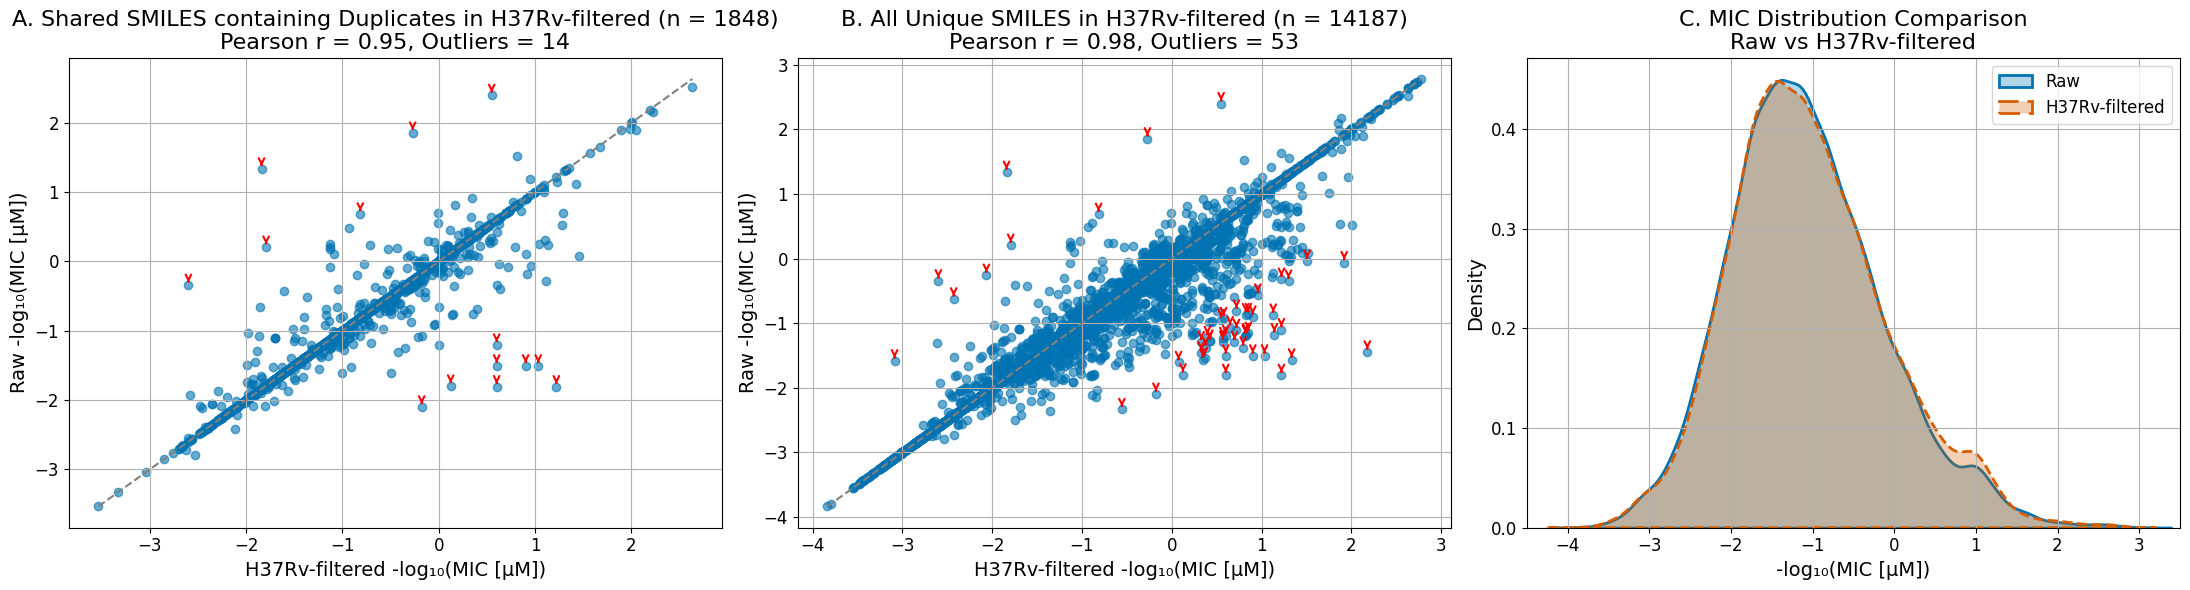

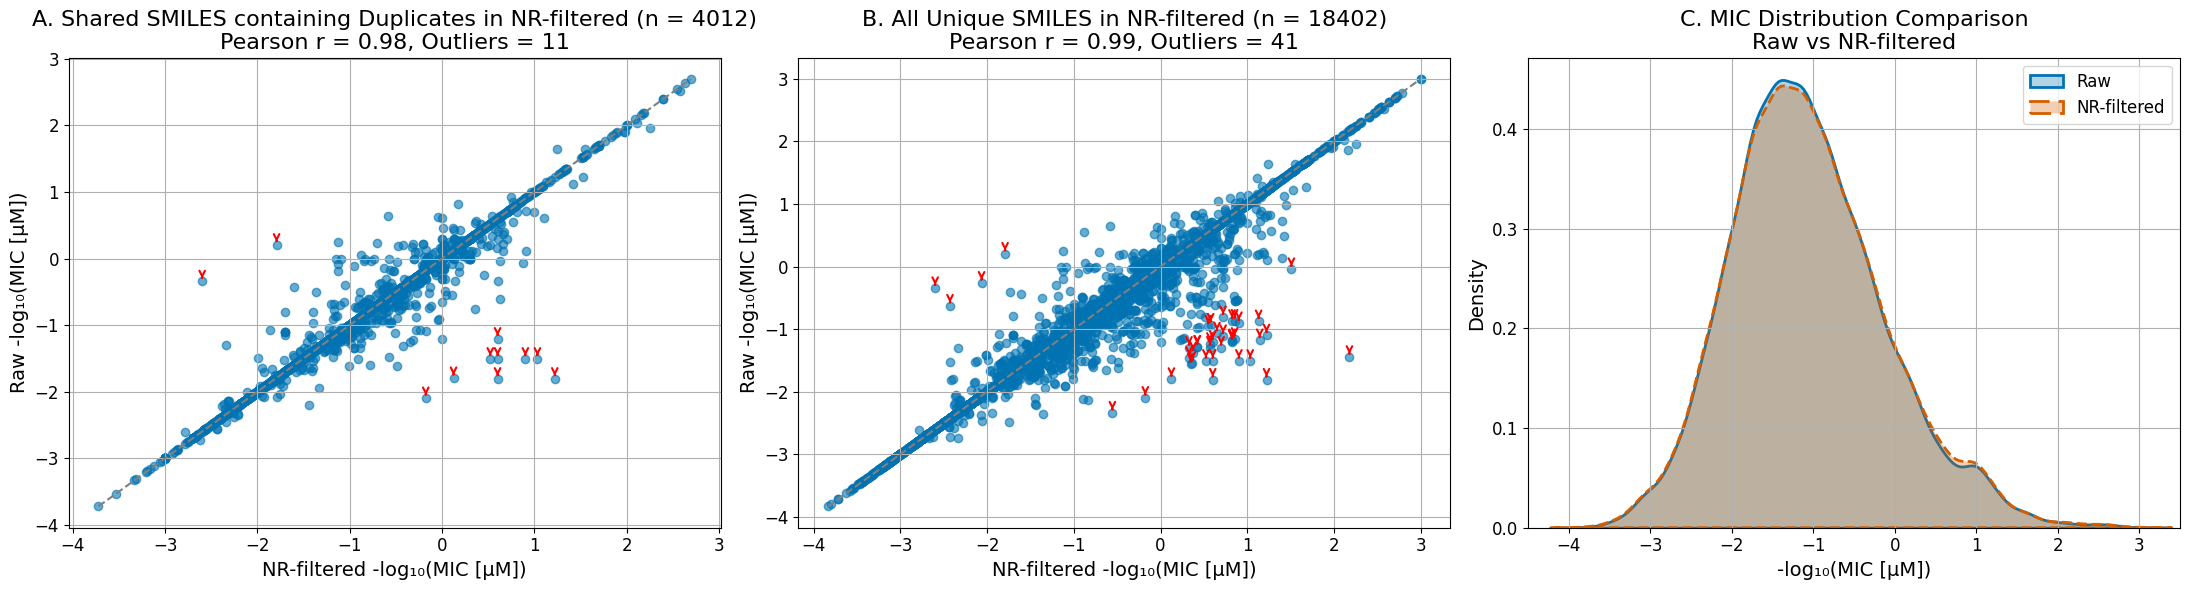

In [42]:
# LLM vs Raw
compare_datasets(h37rv_filtered_data, raw_data, ds1_label="H37Rv-filtered", ds2_label="Raw", output_path="h37rv_vs_raw_logMIC.png")

# NR vs Raw
compare_datasets(nr_filtered_data, raw_data, ds1_label="NR-filtered", ds2_label="Raw", output_path="nr_vs_raw_logMIC.png")